# Creating Helper Functions

In [32]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
%matplotlib inline

In [33]:
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)
        

In [34]:
def run_command(c):
    with sqlite3.connect('chinnok.db') as conn:
        conn.isolation_level = None
        conn.execute(c)
    

In [35]:
def show_tables():
    q='''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ('table','view')
    '''
    return run_query(q)

# Selecting Albums to Purchase

In [36]:
query = '''
WITH custs_in_usa AS
    (
        SELECT 
            il.*
        FROM invoice_line il
        INNER JOIN invoice i ON il.invoice_id = i.invoice_id
        INNER JOIN customer c ON c.customer_id = i.customer_id
        WHERE c.country = "USA")
        
SELECT
    g.name genre_name,
    COUNT(ciu.track_id) no_of_tracks,
    100*(CAST(COUNT(ciu.track_id) AS float))/(SELECT 
    COUNT(*) FROM custs_in_usa) no_of_tracks_percent
FROM custs_in_usa ciu
INNER JOIN track t ON t.track_id = ciu.track_id
INNER JOIN genre g ON g.genre_id = t.genre_id
GROUP BY genre_name
ORDER BY no_of_tracks DESC
LIMIT 10
'''
run_query(query)

,genre_name,no_of_tracks,no_of_tracks_percent
0,Rock,561,53.377735
1,Alternative & Punk,130,12.369172
2,Metal,124,11.798287
3,R&B/Soul,53,5.042816
4,Blues,36,3.425309
5,Alternative,35,3.330162
6,Latin,22,2.093245
7,Pop,22,2.093245
8,Hip Hop/Rap,20,1.902950
9,Jazz,14,1.332065


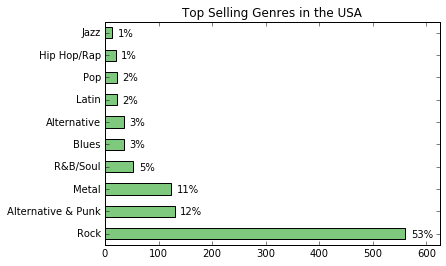

In [37]:
genre_sales_usa = run_query(query)
genre_sales_usa.set_index("genre_name", inplace=True, drop=True)

genre_sales_usa["no_of_tracks"].plot.barh(
    title="Top Selling Genres in the USA",
    xlim=(0, 625),
    colormap=plt.cm.Accent
)

plt.ylabel('')

for i, label in enumerate(list(genre_sales_usa.index)):
    score = genre_sales_usa.loc[label, "no_of_tracks"]
    label = (genre_sales_usa.loc[label, "no_of_tracks_percent"]
            ).astype(int).astype(str) + "%"
    plt.annotate(str(label), (score + 10, i - 0.15))

plt.show()

# Analyzing Employee sales Performance

In [38]:
sales_to_each_agent = '''
WITH agent_custs AS
    (
        SELECT
            c.customer_id,
            e.employee_id
        FROM employee e
        LEFT JOIN customer c ON e.employee_id = c.support_rep_id 
        GROUP BY c.customer_id),
    
    cust_total AS
    (
         SELECT
            customer_id,
            SUM(total) indi_total_purchase
        FROM invoice
        GROUP BY customer_id
        ),
        
    agent_total AS
    (
        SELECT 
            agent_custs.employee_id,
            cust_total.customer_id,
            cust_total.indi_total_purchase
        FROM agent_custs
        LEFT JOIN cust_total ON agent_custs.customer_id = 
        cust_total.customer_id
        )
        
SELECT
    e.first_name || " " || e.last_name employee_name,
    SUM(at.indi_total_purchase) total_sales
FROM agent_total at
INNER JOIN employee e ON e.employee_id = at.employee_id
WHERE employee_name != "Laura Callahan"
GROUP BY at.employee_id
ORDER BY at.employee_id 
'''
run_query(sales_to_each_agent)

,employee_name,total_sales
0,Jane Peacock,1731.51
1,Margaret Park,1584.00
2,Steve Johnson,1393.92


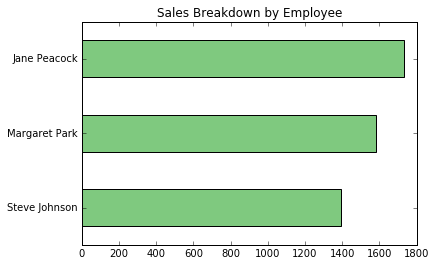

In [39]:
employee_sales = run_query(sales_to_each_agent)

employee_sales.set_index("employee_name", drop=True, inplace=True)
employee_sales.sort_values("total_sales", inplace=True)
employee_sales.plot.barh(
    legend=False,
    title='Sales Breakdown by Employee',
    colormap=plt.cm.Accent
)
plt.ylabel('')
plt.show()


# Analyzing Sales by Country

In [40]:
country_analysis="""WITH indi_custs AS
    (
        SELECT 
            c.customer_id,
            c.country,
            COUNT(i.invoice_id) no_of_orders,
            SUM(i.total) total_expense
        FROM customer c
        LEFT JOIN invoice i ON i.customer_id = c.customer_id
        GROUP BY 1
        ORDER BY 1
        ),
        indi_country AS
        (
            SELECT
                ic.country,
                COUNT(ic.customer_id) no_of_customers,
                SUM(ic.no_of_orders) total_orders,
                SUM(ic.total_expense) total_sales
            FROM indi_custs ic
            GROUP BY 1
            ORDER BY 2),
        sorted_countries AS
        (
             SELECT 
                CASE
                    WHEN no_of_customers=1 THEN "Other"
                    ELSE ic.country
                END AS country,
                SUM(no_of_customers) total_customers,
                SUM(total_orders) total_orders,
                SUM(total_sales) total_sales
            FROM indi_country ic
            GROUP BY 1
            ORDER BY total_sales DESC)
            
SELECT 
    new.country,
    new.total_customers,
    new.total_sales,
    CAST(new.total_sales AS float)/CAST(new.total_customers 
    AS float) avg_sales_per_customer,
    CAST(new.total_sales AS float)/CAST(new.total_orders
    AS float) avg_order_value
FROM
    (SELECT sc.*,
    CASE
        WHEN country = 'Other' THEN 1
        ELSE 0
    END AS sort
    FROM sorted_countries sc
    ORDER BY sort) new
"""
run_query(country_analysis)

,country,total_customers,total_sales,avg_sales_per_customer,avg_order_value
0,USA,13,1040.49,80.037692,7.942672
1,Canada,8,535.59,66.948750,7.047237
2,Brazil,5,427.68,85.536000,7.011148
3,France,5,389.07,77.814000,7.781400
4,Germany,4,334.62,83.655000,8.161463
5,Czech Republic,2,273.24,136.620000,9.108000
6,United Kingdom,3,245.52,81.840000,8.768571
7,Portugal,2,185.13,92.565000,6.383793
8,India,2,183.15,91.575000,8.721429
9,Other,15,1094.94,72.996000,7.448571


# Visualizing Sales by Country

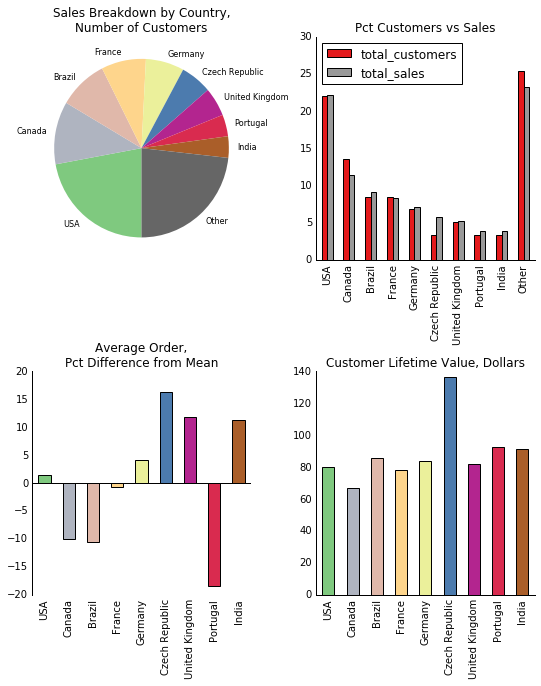

In [41]:
country_metrics = run_query(country_analysis)
country_metrics.set_index("country", drop=True, inplace=True)
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country_metrics.shape[0])]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 10))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)


# top left
sales_breakdown = country_metrics["total_sales"].copy().rename('')
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title='Sales Breakdown by Country,\nNumber of Customers',
    colormap=plt.cm.Accent,
    fontsize=8,
    wedgeprops={'linewidth':0}
    
)

# top right
cvd_cols = ["total_customers","total_sales"]
custs_vs_dollars = country_metrics[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
custs_vs_dollars.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title="Pct Customers vs Sales"
)
ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)


# bottom left
avg_order = country_metrics["avg_order_value"].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.drop("Other", inplace=True)
difference_from_avg.plot.bar(
    ax=ax3,
    color=colors,
    title="Average Order,\nPct Difference from Mean"
)
ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

# bottom right
ltv = country_metrics["avg_sales_per_customer"].copy()
ltv.index.name = ''
ltv.drop("Other",inplace=True)
ltv.plot.bar(
    ax=ax4,
    color=colors,
    title="Customer Lifetime Value, Dollars"
)
ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.show()

# Albums vs Individual Tracks

In [48]:
q="""
WITH album_track AS
    (
        SELECT album_id, track_id
        FROM track
        ORDER BY album_id),
    invoice_track AS
    (
        SELECT 
            i.invoice_id,
            il.track_id
        FROM invoice i
        LEFT JOIN invoice_line il ON il.invoice_id = i.invoice_id
        ORDER BY i.invoice_id)
    
SELECT 
    it.invoice_id,
    CASE
        WHEN
            (
            (
            SELECT at.track_id FROM album_track at
            WHERE at.album_id = (SELECT t.album_id FROM track t
                                  WHERE t.track_id = it.track_id)
                                  )
            EXCEPT
            SELECT track_id FROM invoice_track) IS NULL
            AND
            (SELECT track_id FROM invoice_track
            EXCEPT
            SELECT track_id FROM album_track) IS NULL) 'Yes'
            ELSE 'No'
    END AS album_purchase
     FROM invoice_track
"""
run_query(q)

DatabaseError: Execution failed on sql '
WITH album_track AS
    (
        SELECT album_id, track_id
        FROM track
        ORDER BY album_id),
    invoice_track AS
    (
        SELECT 
            i.invoice_id,
            il.track_id
        FROM invoice i
        LEFT JOIN invoice_line il ON il.invoice_id = i.invoice_id
        ORDER BY i.invoice_id)
    
SELECT 
    it.invoice_id,
    CASE
        WHEN
            ((SELECT track_id FROM album_track
            EXCEPT
            SELECT track_id FROM invoice_track) IS NULL
            AND
            (SELECT track_id FROM invoice_track
            EXCEPT
            SELECT track_id FROM album_track) IS NULL) 'Yes'
            ELSE 'No'
    END AS album_purchase
     FROM invoice_track
': near "'Yes'": syntax error